analyze_video() called!
measure_radial_intensities() called!
plot_radial_segment_intensities() called!


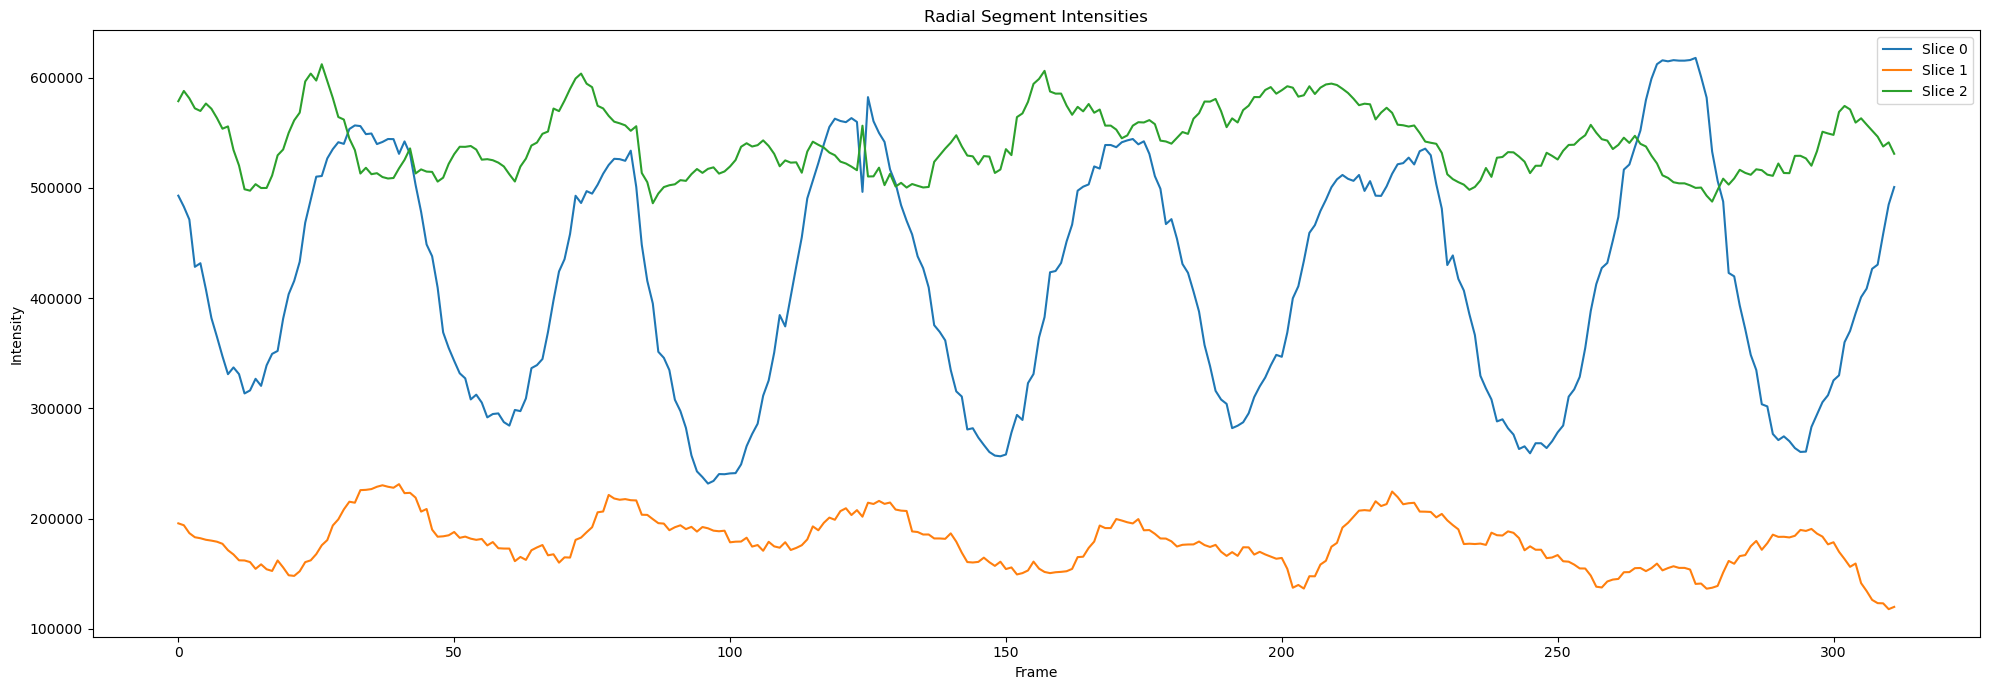

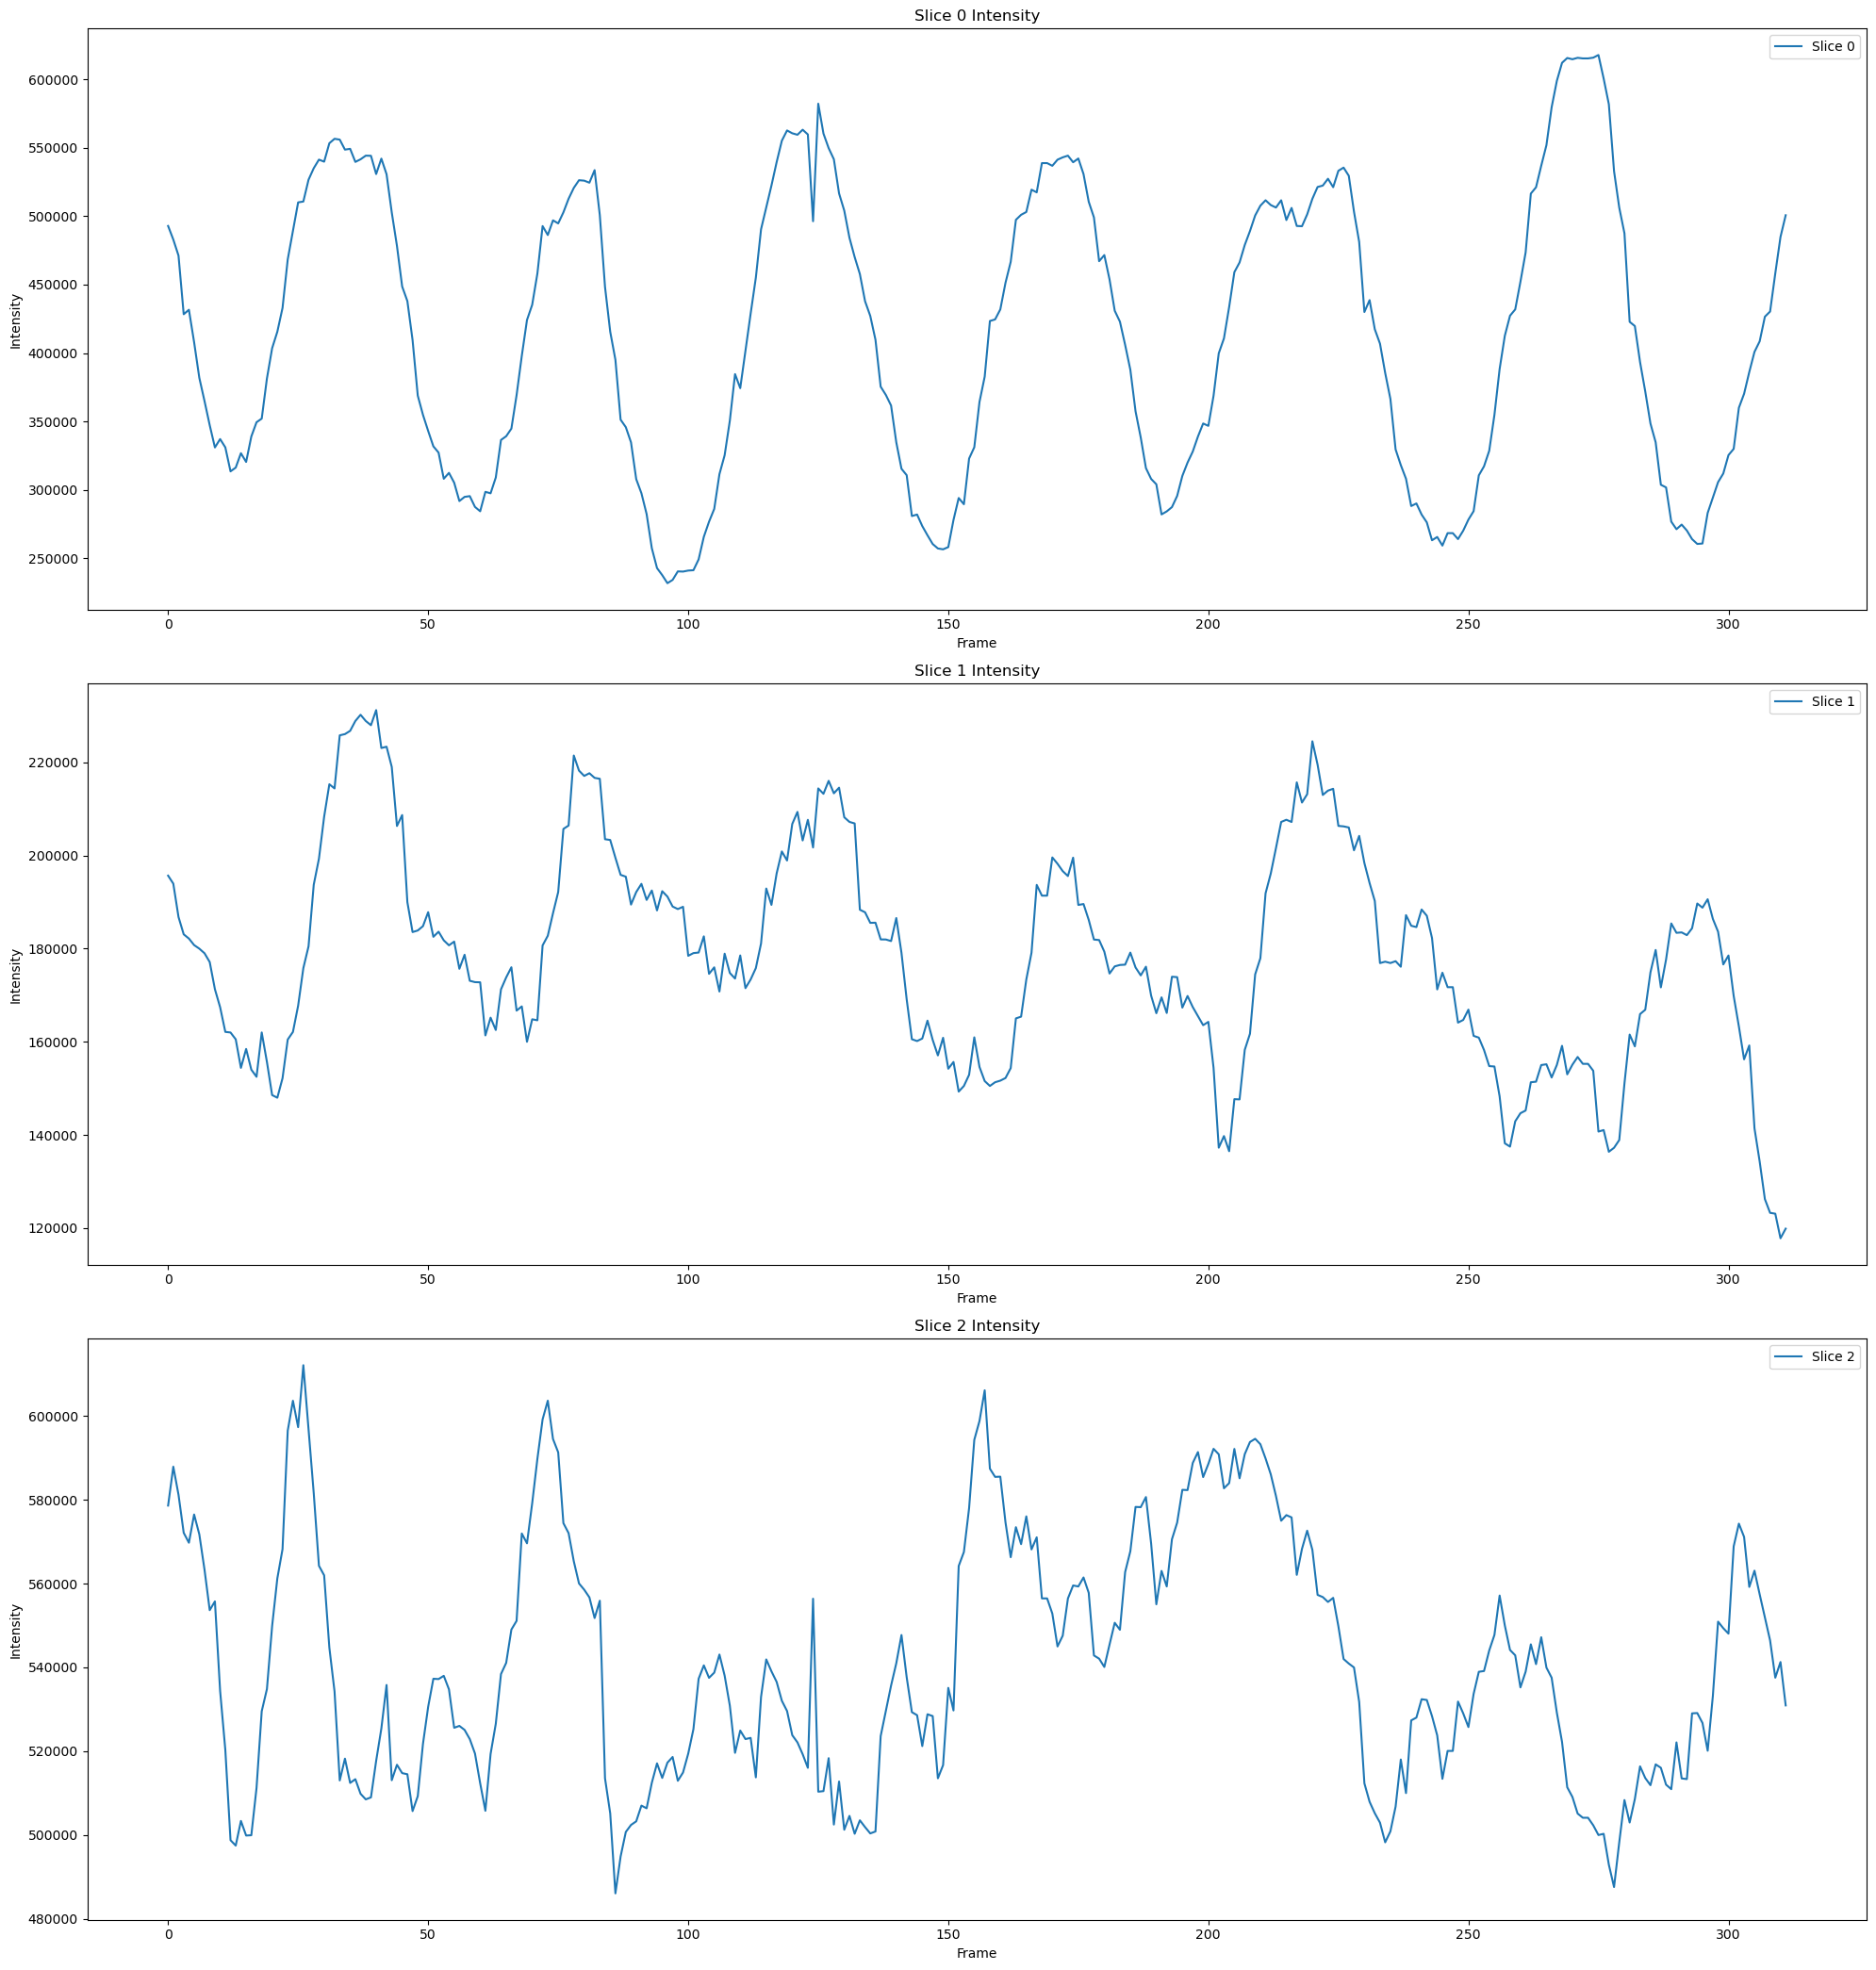

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import math
import core.knee_segmentation as ks
from typing import Tuple, List
from utils import io, views, utils
from config import VERBOSE, OUTPUT
from core import data_processing as dp
import core.radial_segmentation as rdl
import copy

def get_closest_pt_to_edge(mask:np.ndarray, edge:str) -> Tuple[int,int]:
    """
    Finds the closest point in a binary mask to one edge of the frame.
    Inputs:
        mask (np.ndarray): A binary image mask.
        edge (str): The edge {t,r,b,l} of the frame we want the point closest to.
    Outputs:
        (int, int): A tuple (x, y) returning the coordinates of the desired point.
    """

    y, x = np.nonzero(mask) # Validate binary mask
    if y.size == 0:
        return None  # No points found

    # Get all closest points to the edge
    edge_funcs = {
        "t": np.argmin(y),  # Top (min y)
        "r": np.argmax(x),   # Right (max x)
        "b": np.argmax(y),  # Bottom (max y)
        "l": np.argmin(x),  # Left (min x)
    }

    i = edge_funcs[edge]
    pt = x[i], y[i]

    return pt

def get_closest_pts_to_edge(video:np.ndarray, edge:str) -> List[Tuple[int,int]]:
    "Gets the closest points to an edge for an entire video. Edge = {t,r,b,l}"
    if VERBOSE: print("get_closest_pts_to_edge() called!")

    pts = []
    for cf, frame in enumerate(video):
        pt = get_closest_pt_to_edge(frame, edge)
        pts.append(pt)
    
    return pts

def _get_N_points_on_circle(circle_ctr:Tuple[int,int], ref_pt:Tuple[int,int], N:int, radius_scale:int=1) -> np.ndarray:
    """Returns N equally spaced points on a circle as a NumPy array.
    
    Args:
        circle_ctr: (x, y) center of the circle.
        ref_pt: (x, y) reference point on the circle.
        N: Number of points to generate.

    Returns:
        NumPy array of shape (N, 2) containing the (x, y) points.
    """
    cx, cy = circle_ctr
    rx, ry = ref_pt
    radius = math.hypot(rx - cx, ry - cy)*radius_scale
    start_angle = math.atan2(ry - cy, rx - cx)
    
    circle_pts = np.zeros((N, 2), dtype=np.int32)
    for i in range(N):
        angle = start_angle - 2 * math.pi * i / N
        x = cx + radius * math.cos(angle)
        y = cy + radius * math.sin(angle)
        circle_pts[i] = [round(x), round(y)]
    
    return circle_pts

def get_N_points_on_circle(circle_ctrs:np.ndarray, ref_pts:np.ndarray, N:int, radius_scale:int=1) -> np.ndarray:
    """Gets N points on a circle for an entire video.
    
    Returns:
        NumPy array of shape (frames, N, 2) containing all points,
        or (frames, N, 2) zeros for None inputs.
    """
    if VERBOSE: 
        print("get_N_points_on_circle() called!")

    nfs = circle_ctrs.shape[0] # Shape (nfs, npts, 2)
    if nfs != ref_pts.shape[0]: 
        raise ValueError(f"Input args must have the same number of rows. Given: {nfs} and {ref_pts.shape[0]}")

    circle_points = []
    for cf in range(nfs):

        ctr = np.asarray(circle_ctrs[cf])[0]
        pts = np.asarray(ref_pts[cf])[0]

        print(ctr, pts)

        if ctr is None or pts is None:
            # Use zeros for missing frames to maintain array structure
            circle_points.append(np.zeros((N, 2), dtype=np.int32))
            continue
        
        circ_pts = _get_N_points_on_circle(ctr, pts, N, radius_scale)
        circle_points.append(circ_pts)
    circle_points = np.array(circle_points)

    return circle_points

def smooth_points(points:List[Tuple[int,int]], window_size:int) -> List[Tuple[int,int]]:
    """Smooths a set of points using a moving average filter"""
    if VERBOSE: print("smooth_points() called!")

    # Compute rolling mean using pandas
    points = pd.DataFrame(points)
    points[0] = points[0].rolling(window_size, min_periods=1, center=True).mean().astype(int)
    points[1] = points[1].rolling(window_size, min_periods=1, center=True).mean().astype(int)

    # Cast back to list of tuples    
    points = list(points.itertuples(index=False, name=None))

    return points

def estimate_femur_position(mask:np.ndarray) -> Tuple[ np.ndarray, np.ndarray]:
    """Estimates the position of the femur based on an adaptive mean mask. Assumes femur is pointing to the left of the screen.
    
    Returns (femur_endpts, femur_midpts), 
        where femur_endpts is the position of the femur inside the knee, 
        and femur_midpts is a set of points somewhere along the femur 
    """
    if VERBOSE: print("estimate_femur_position() called!")

    mask = mask.copy()

    # Split frame along the middle. TODO: Parameterize the split line?
    spl = 0.5
    nframes,h,w = mask.shape
    mask_top = mask[:,0:int(h*spl),:]
    mask_btm = mask[:,int(h*spl):,:]

    # Get left-most points on top/bottom halves
    topl_pts = get_closest_pts_to_edge(mask_top, "l")
    btml_pts_ = get_closest_pts_to_edge(mask_btm, "l")

    # views.draw_point(mask_top, topl_pts, True) # Validate left-most points
    # views.draw_point(mask_btm, btml_pts_, True)

    # Convert bottom-left coords to the whole mask
    btml_pts = [None] # to maintain 1-indexing. this gets skipped in the next block 
    for pt in btml_pts_[1:]:
        pt = list(pt) # for mutability
        pt[1] = pt[1] + int(h*spl) 
        btml_pts.append(tuple(pt)) # tuple for opencv compatibility

    # views.draw_line(mask, topl_pts, btml_pts) # Validate drawn line

    # Get midpoint of left line 
    midl_pts = [(0,0)]
    for cf in range(1, len(mask)):
        topl_pt = np.array(topl_pts[cf])
        btml_pt = np.array(btml_pts[cf])
        midl_pt = (topl_pt + btml_pt)//2
        midl_pts.append(tuple(midl_pt))

    # Smooth midpoints
    midl_pts[1:] = smooth_points(midl_pts[1:], 5)

    # views.draw_point(mask, midl_pts) # Validate midpoint

    frame_ctr = [(w//2,h//2)]*nframes
    # views.draw_line(mask, midl_pts, frame_ctr) # Validate basic femur estimation

    

    femur_endpts = frame_ctr
    femur_midpts = midl_pts

    return femur_endpts, femur_midpts

def intersect_masks(mask1: np.ndarray, mask2: np.ndarray) -> np.ndarray:
    """
    Performs frame-wise binary AND over all frames in two 3D binary masks.

    Both mask1 and mask2 must have shape (nframes, height, width).
    """
    assert mask1.shape == mask2.shape, "Masks must have the same shape"
    
    nfs,h,w = mask1.shape

    AND_frs = []
    for cf in range(nfs):
        AND_frs.append(mask1[cf] & mask2[cf])
    AND_frs = np.array(AND_frs, dtype=np.uint8)
    
    return AND_frs

def combine_masks(masks:np.ndarray) -> np.ndarray:
    """Takes the frame-wise union of all input masks"""

    # TODO: input validation

    masks = masks.copy()
    nmsks, nfrms, h, w = masks.shape
    
    combined_masks = []
    for cf in range (nfrms):
        
        frame = np.zeros((h,w), dtype=np.uint8)

        for mn in range(nmsks):
            frame = frame | masks[mn, cf]

        combined_masks.append(frame)

    combined_masks = np.array(combined_masks)
    return combined_masks


def get_radial_segments(video:np.ndarray, circle_ctrs:np.ndarray, circle_pts:np.ndarray, thresh_scale:int=0.8) -> Tuple[np.ndarray, np.ndarray]:
    """Gets the radial segments for the video. """
    if VERBOSE: print("get_radial_segments() called!")

    video = video.copy()
    circle_ctrs = np.array(circle_ctrs) # adhoc type cast since downstream operations are buggy without this
    circle_pts = np.array(circle_pts)

    # TODO: input validation

    # Get Otsu masks
    otsu_masks = ks.get_otsu_masks(video, thresh_scale=thresh_scale)
    # views.show_frames(otsu_masks) # Validate otsu masks

    # Get bisection mask for every point on the circle
    nfs, h, w = video.shape
    _, N, _ = circle_pts.shape
    bsct_masks = np.empty((N, nfs, h,w), dtype=np.uint8) # dimensions (N_masks, nframes, h, w)
    for n in range(N):
        bsct_masks[n] = ks.get_bisecting_masks(video, circle_pts[:,n], circle_ctrs) 
        # views.show_frames(bsct_masks[n]) # Validate bisecting masks

    # Get radial slices
    radial_slices = np.empty((N, nfs, h,w), dtype=np.uint8) # dimensions (N_masks, nframes, h, w)
    for n in range(N):
        radial_slices[n] = intersect_masks(bsct_masks[n], ~bsct_masks[n-1])
        # views.show_frames(radial_slices[n]) # Validate radial slices

    # Get radial masks
    radial_masks = np.empty((N, nfs, h,w), dtype=np.uint8) # dimensions (N_masks, nframes, h, w)
    for n in range(N):
        radial_masks[n] = intersect_masks(radial_slices[n], otsu_masks)
        # views.show_frames(radial_masks[n]) # Validate radial masks

    # Get radial regions
    otsu_region = intersect_masks(otsu_masks, video)
    radial_regions = np.empty((N, nfs, h,w), dtype=np.uint8) # dimensions (N_masks, nframes, h, w)
    for n in range(N):
        radial_regions[n] = intersect_masks(radial_slices[n], otsu_region)
        # views.show_frames(radial_masks[n]) # Validate radial regions

    return radial_regions, radial_masks

def analyze_all_aging_knees(video, radial_masks, radial_regions, show_figs=True, save_figs=False, figsize=(9,17)):
    aging_versions = ["aging-1", "aging-2", "aging-3"]
    
    for aging_label in aging_versions:
        print(f"\n=== Processing {aging_label} ===")

        # Load metadata 
        _, metadata = io.load_aging_knee_coords("../data/198_218 updated xy coordinates for knee-aging 250426.xlsx", aging_label)

        # Manually assign left/middle/right knee
        l_mask = combine_masks(np.concatenate([radial_masks[11:], radial_masks[0:1]], axis=0)) # 12-15 and 0
        m_mask = combine_masks(radial_masks[8:11])
        r_mask = combine_masks(radial_masks[1:8])

        l_region = combine_masks(np.concatenate([radial_regions[11:], radial_regions[0:1]], axis=0)) # 12-15 and 0
        m_region = combine_masks(radial_regions[8:11])
        r_region = combine_masks(radial_regions[1:8])

        # Validate segments
        v_out = views.draw_radial_masks(video, np.array([l_mask, m_mask, r_mask]), show_video=False)
        if OUTPUT: io.save_avi("aging_knee_radial_seg_LMR_(new_method).avi", v_out)

        masks = {'l': l_mask, 'm': m_mask, 'r': r_mask} 
        regions = {'l': l_region, 'm': m_region, 'r': r_region}
        keys = ['l','m','r']

        # Get intensity data
        raw_intensities = dp.measure_region_intensities(regions, masks, keys)
        normalized_intensities = dp.measure_region_intensities(regions, masks, keys, normalized=True)
        radial_intensities = dp.measure_radial_intensities(np.array([l_region, m_region, r_region]))

        # Validate intensity data
        # show_figs=True
        # save_figs=False
        # figsize=(9,17)
        views.plot_three_intensities(raw_intensities, metadata, show_figs, save_figs, vert_layout=True, figsize=figsize)
        views.plot_three_intensities(normalized_intensities, metadata, show_figs, save_figs, vert_layout=True, figsize=figsize, normalized=True)
        # views.plot_radial_segment_intensities(radial_intensities, f0=1, fN=None)

def analyze_video(video, radial_masks, radial_regions, lft:Tuple[int,int], mdl:Tuple[int,int], rgt:Tuple[int,int], 
                  show_figs:bool=True, save_figs:bool=False, fig_size:Tuple[int,int]=(17,9)) -> None:
    """Analyzes all frames in a radially-segmented knee fluorescence video"""
    if VERBOSE: print("analyze_video() called!")

    video = video.copy()
    nfs, h, w = video.shape

    assert nfs == radial_masks.shape[1] 
    assert nfs == radial_regions.shape[1]

    masks = {'l': combine_masks(rdl.circular_slice(radial_masks, lft)), 
             'm': combine_masks(rdl.circular_slice(radial_masks, mdl)),
             'r': combine_masks(rdl.circular_slice(radial_masks, rgt))}
    
    regions = {'l': combine_masks(rdl.circular_slice(radial_regions, lft)), 
             'm': combine_masks(rdl.circular_slice(radial_regions, mdl)),
             'r': combine_masks(rdl.circular_slice(radial_regions, rgt))}
    
    keys = ['l','m','r']
    
    total_sums = dp.measure_radial_intensities(np.asarray([regions["l"], regions["m"], regions["r"]])) # Generalized function for arbitrarily many slices
    views.plot_radial_segment_intensities(total_sums, vert_layout=True) 
    # I see now why matplotlib implements figures as objects... I can't modify the labels on these plots after the fact 

    return


lft=(12,1)
mdl=(8,12)
rgt=(1,8)

analyze_video(video, radial_masks, radial_regions, lft, mdl, rgt, show_figs=True, save_figs=False, fig_size=None)


main() called!
load_nparray() called!
crop_video_square() called!
rotate_video() called!
crop_video_square() called!
blur_video() called!
mask_adaptive() called!
get_otsu_masks() called!
morph_erode() called!
interior_mask() called!
morph_close() called!
show_frames() called!
sample_femur_interior_pts() called!
draw_points() called!
show_frames() called!
draw_points() called!
show_frames() called!
filter_outlier_points_centroid() called!
get_centroid_pts() called!
0 16.64331697709324
1 16.64331697709324
2 17.0
3 14.866068747318506
4 14.866068747318506
5 15.620499351813308
6 16.278820596099706
7 15.620499351813308
8 15.620499351813308
9 16.401219466856727
10 15.620499351813308
11 15.0
12 14.212670403551895
13 14.212670403551895
14 14.212670403551895
15 14.212670403551895
16 14.212670403551895
17 15.620499351813308
18 15.620499351813308
19 16.278820596099706
20 17.69180601295413
21 17.69180601295413
22 17.69180601295413
23 48.02082881417188
24 42.80186911806539
25 19.1049731745428
26 46.

C:\Users\olimoon\Documents\Development\Applied Math MSc 2024-2026\knee segmentation\src\utils\io.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords.index = coords.index.to_series().fillna(method="ffill").astype(int)


draw_radial_masks() called!
measure_region_intensities() called!
measure_region_intensities() called!
 > normalized!
measure_radial_intensities() called!
plot_three_intensities() called!
l
m
r


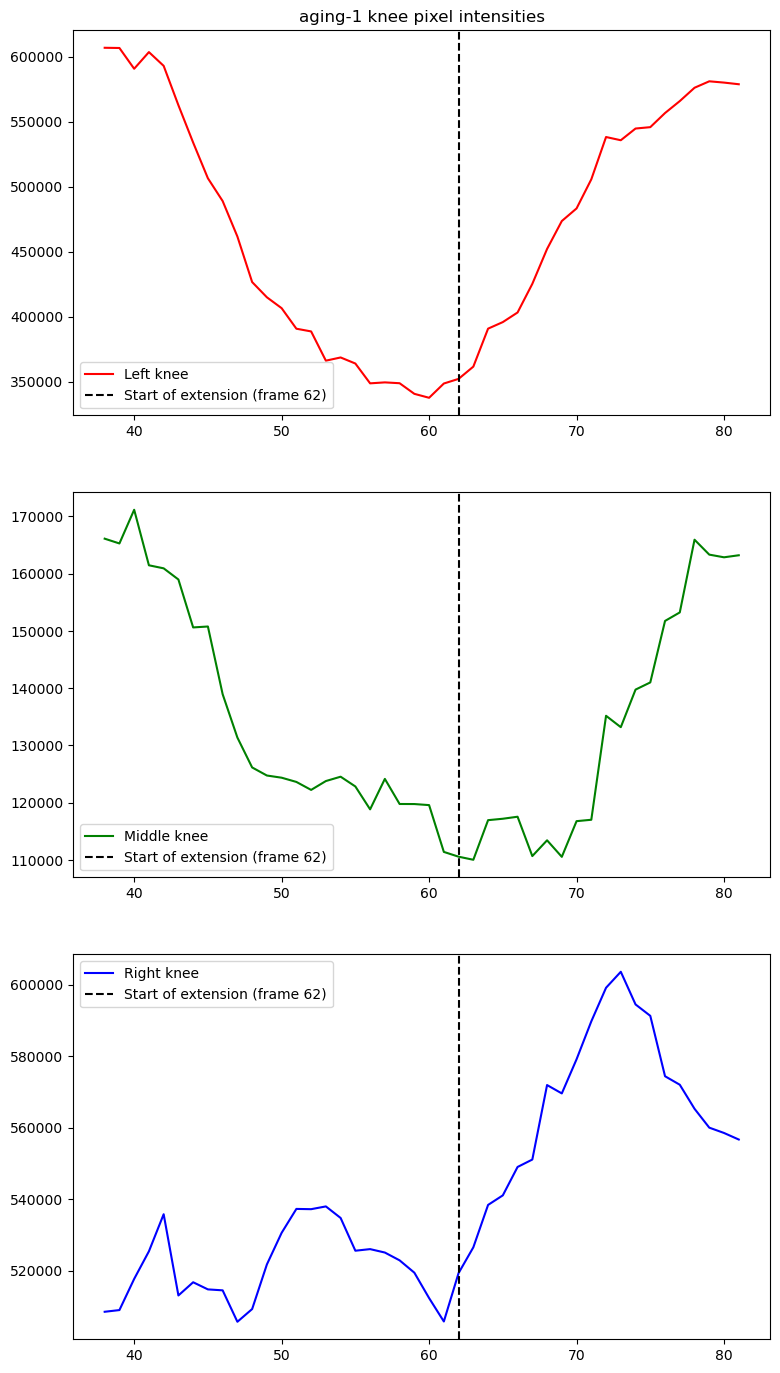

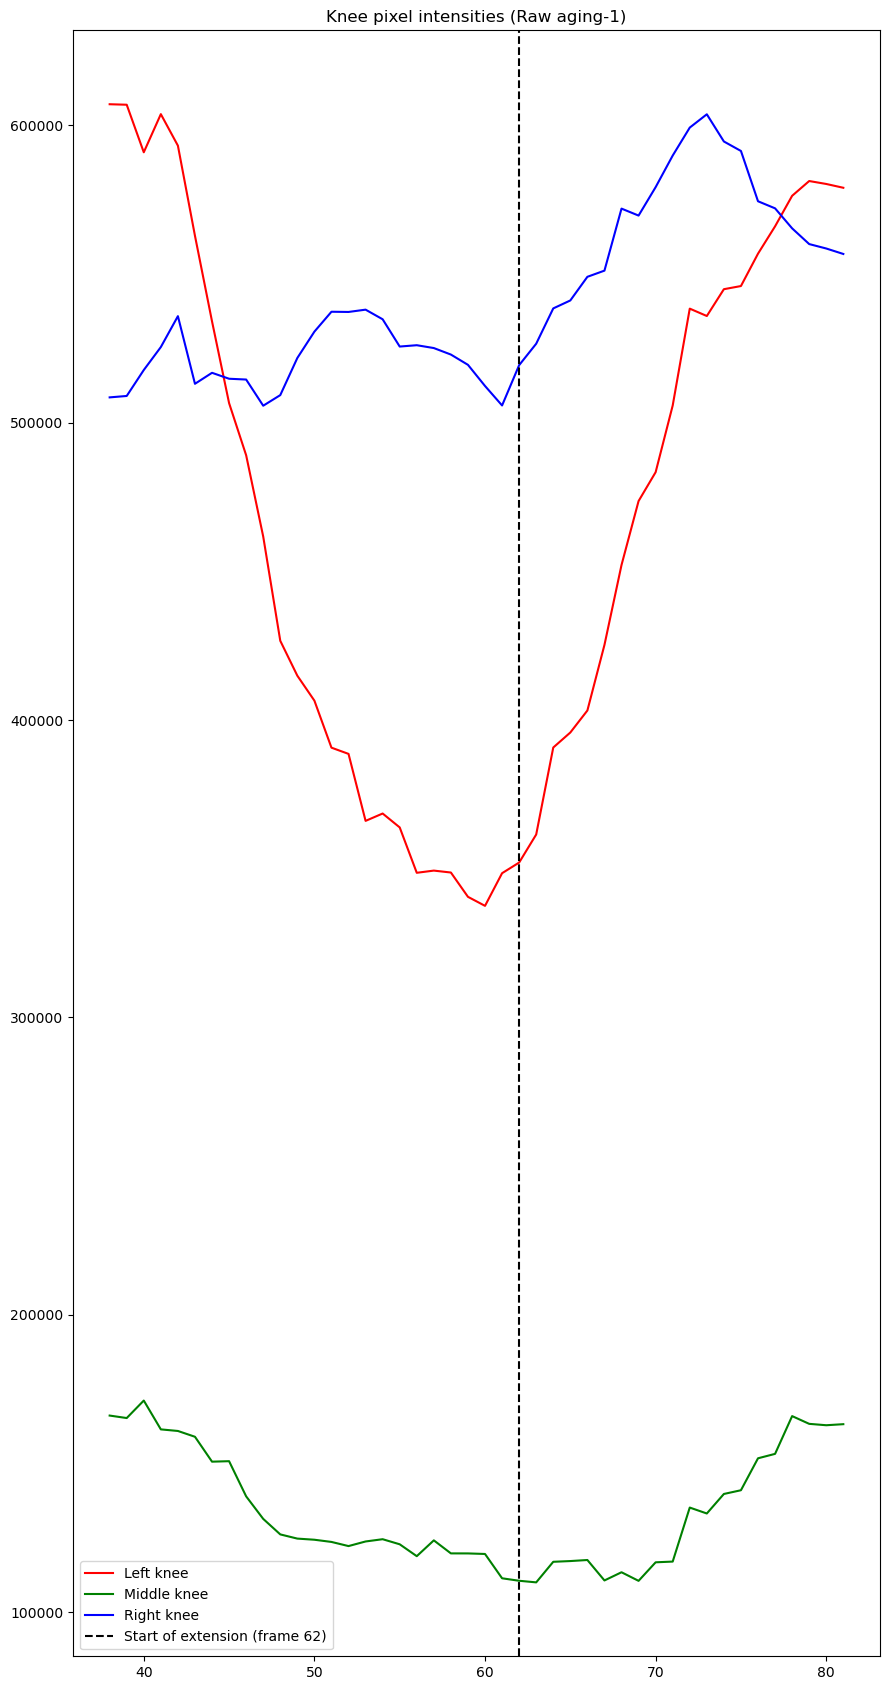

plot_three_intensities() called!
l
m
r


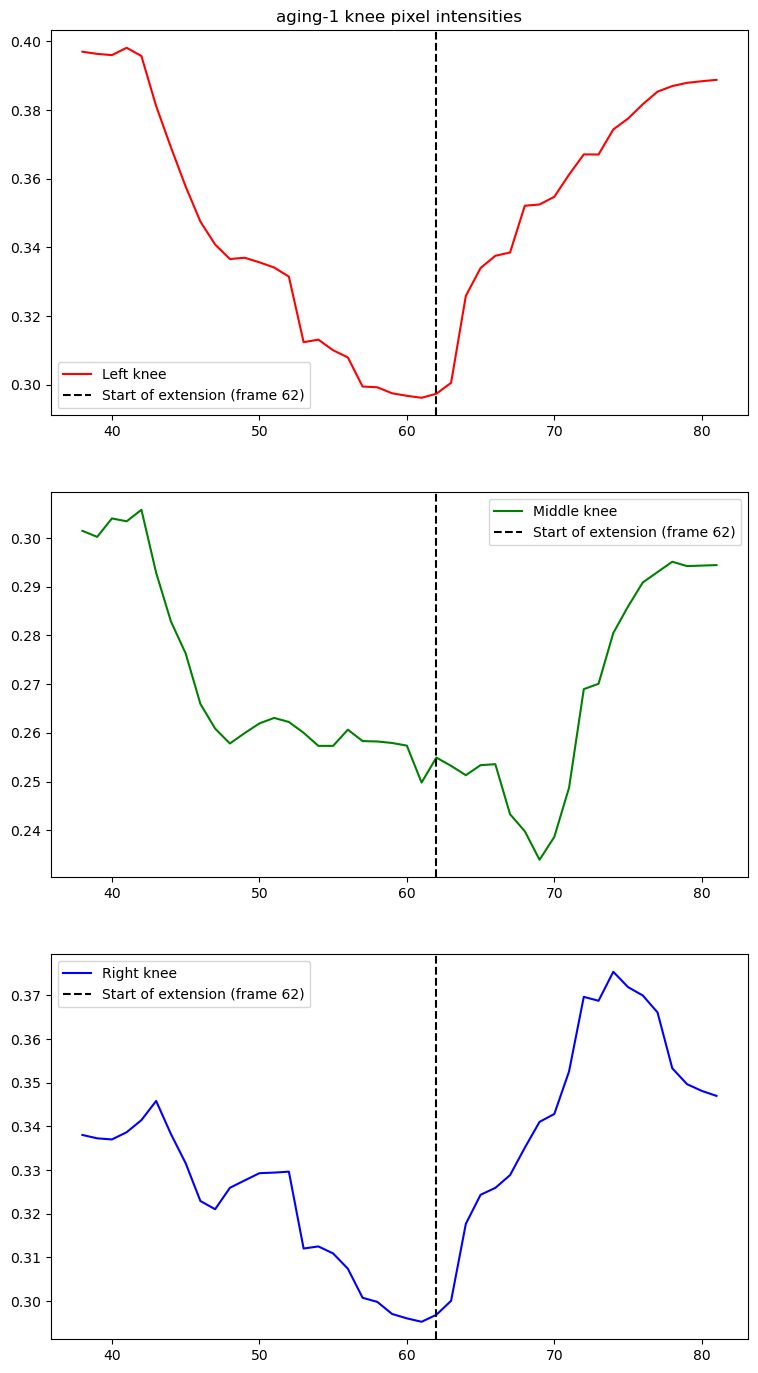

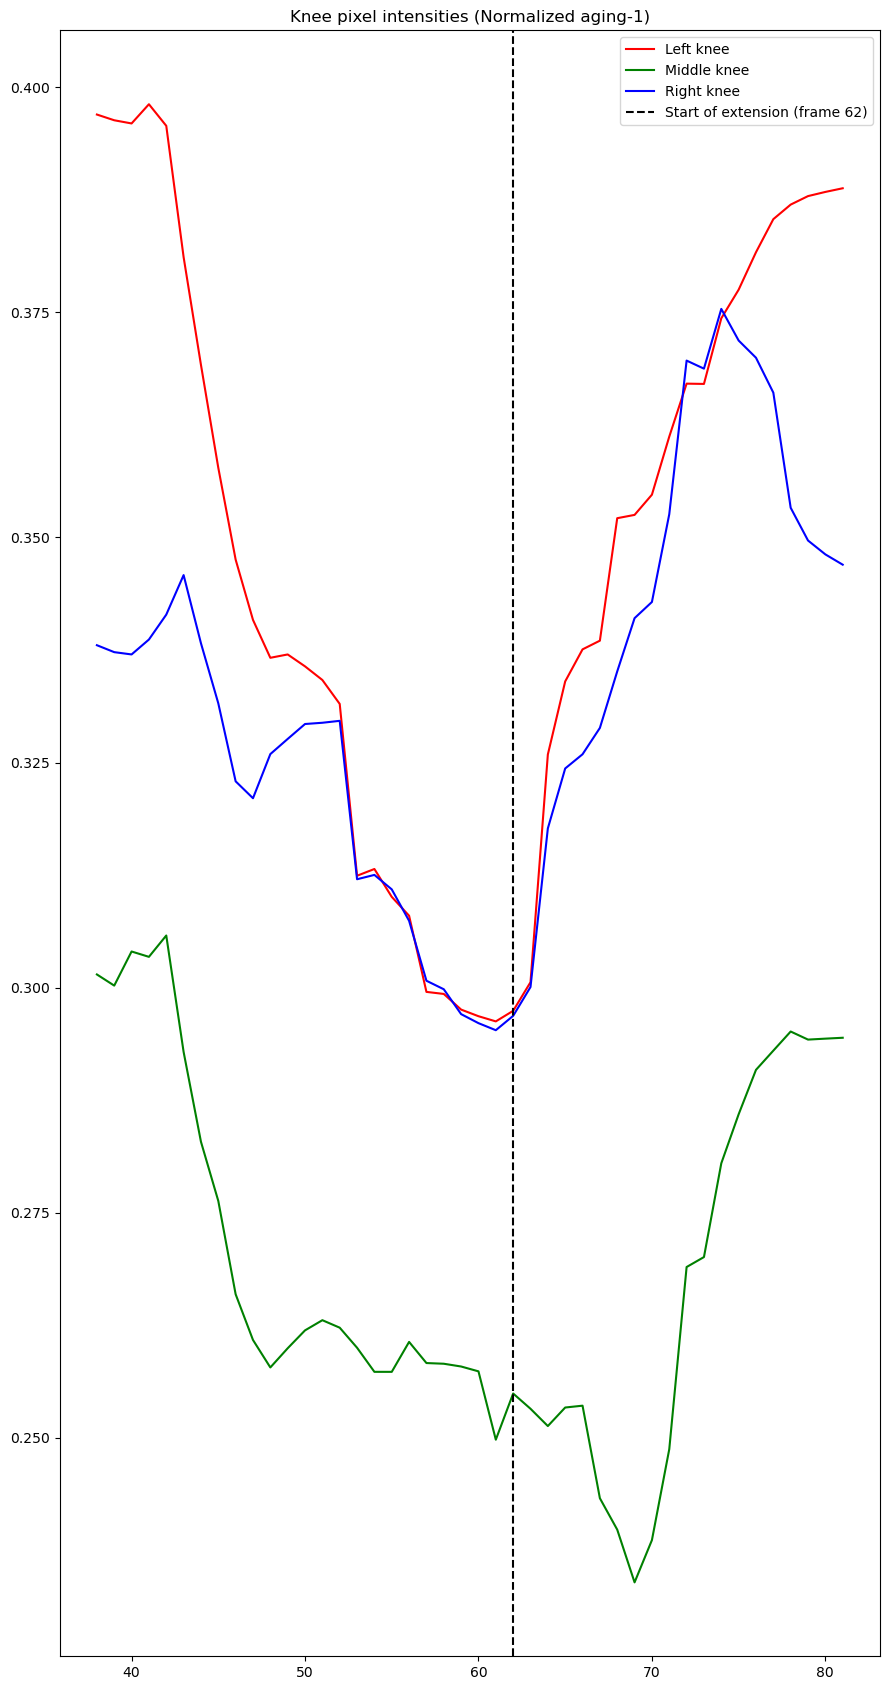


=== Processing aging-2 ===
load_aging_knee_coords() called!


C:\Users\olimoon\Documents\Development\Applied Math MSc 2024-2026\knee segmentation\src\utils\io.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords.index = coords.index.to_series().fillna(method="ffill").astype(int)


draw_radial_masks() called!
measure_region_intensities() called!
measure_region_intensities() called!
 > normalized!
measure_radial_intensities() called!
plot_three_intensities() called!
l
m
r


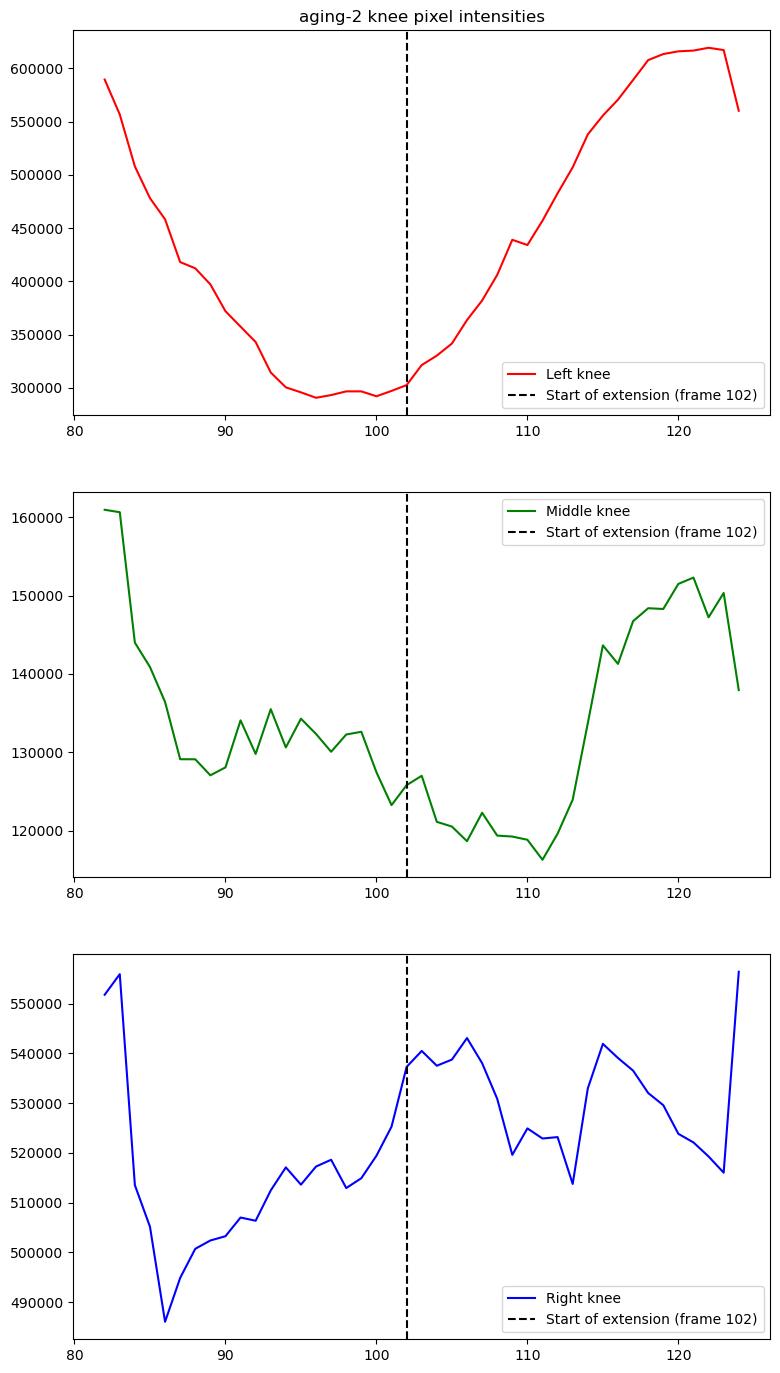

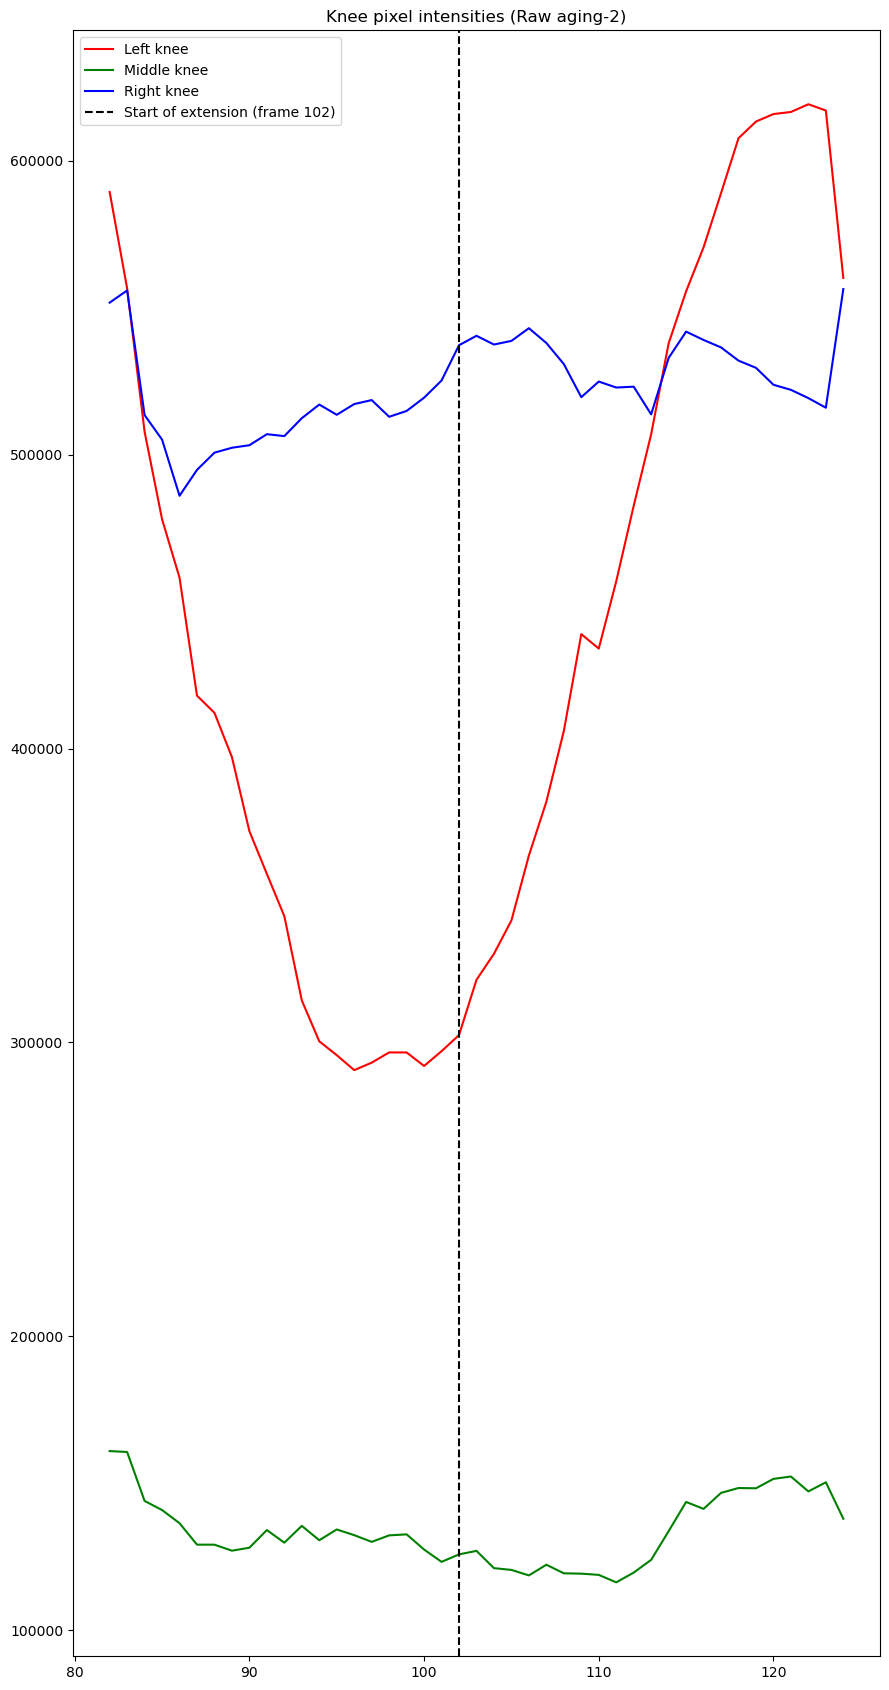

plot_three_intensities() called!
l
m
r


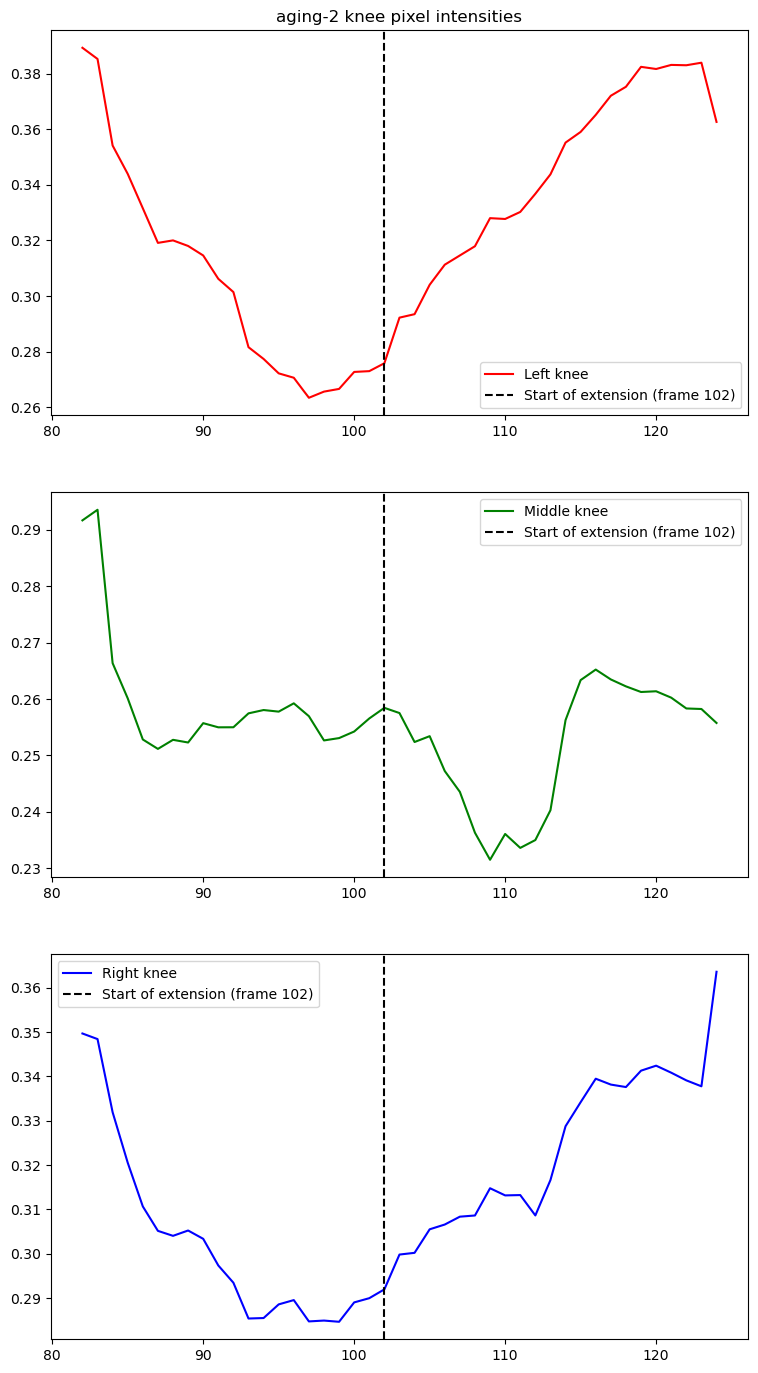

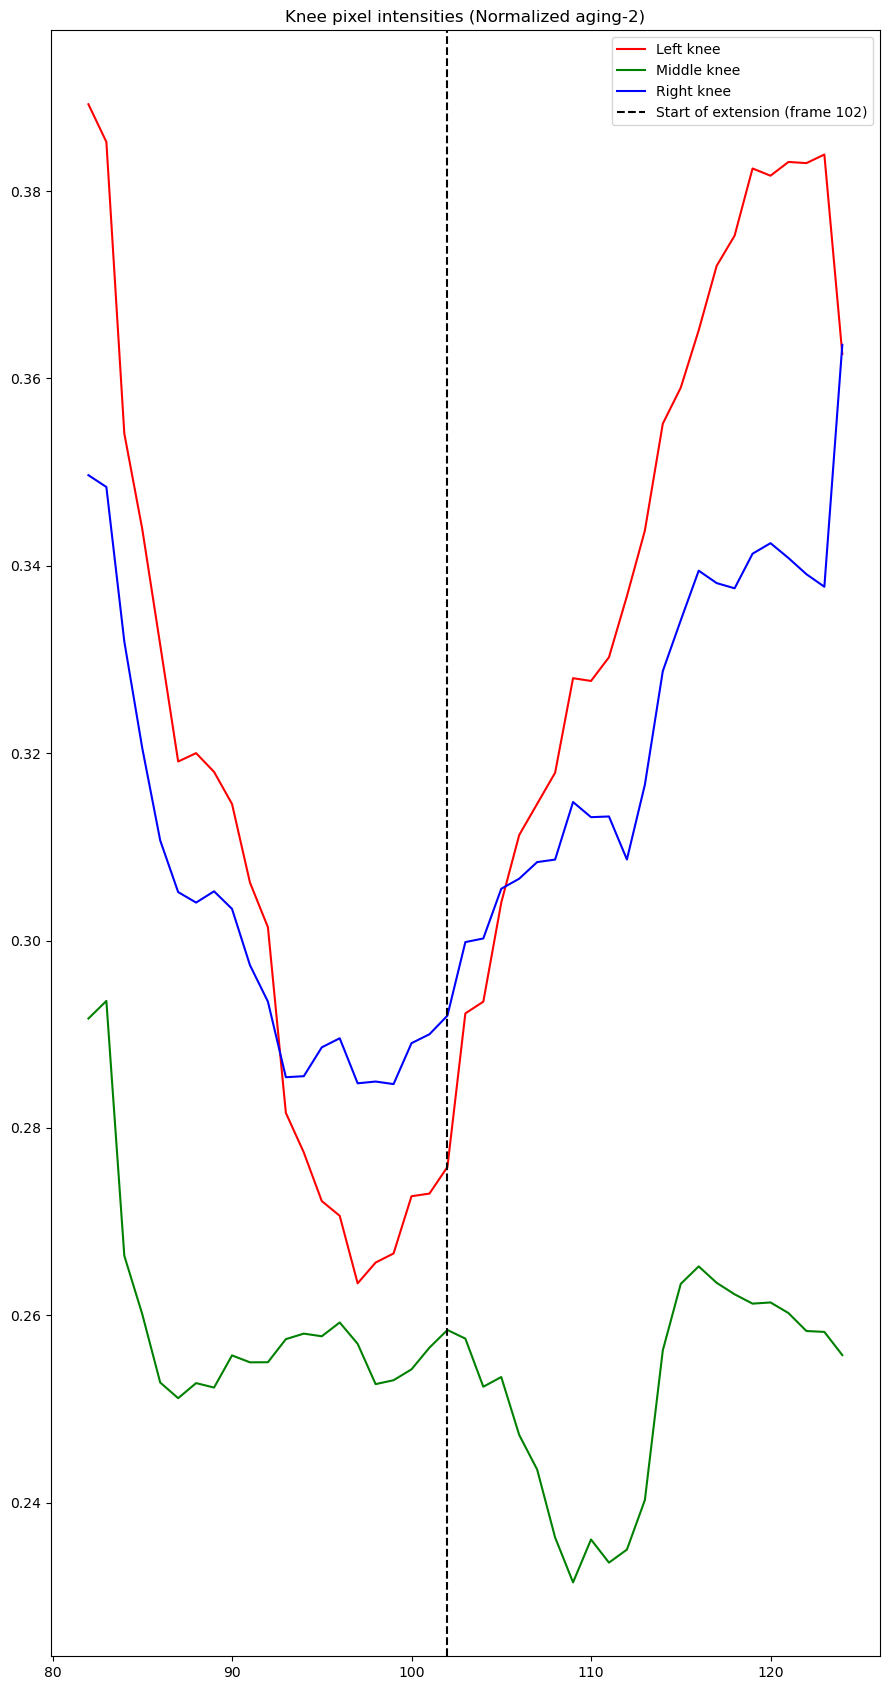


=== Processing aging-3 ===
load_aging_knee_coords() called!


C:\Users\olimoon\Documents\Development\Applied Math MSc 2024-2026\knee segmentation\src\utils\io.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords.index = coords.index.to_series().fillna(method="ffill").astype(int)


draw_radial_masks() called!
measure_region_intensities() called!
measure_region_intensities() called!
 > normalized!
measure_radial_intensities() called!
plot_three_intensities() called!
l
m
r


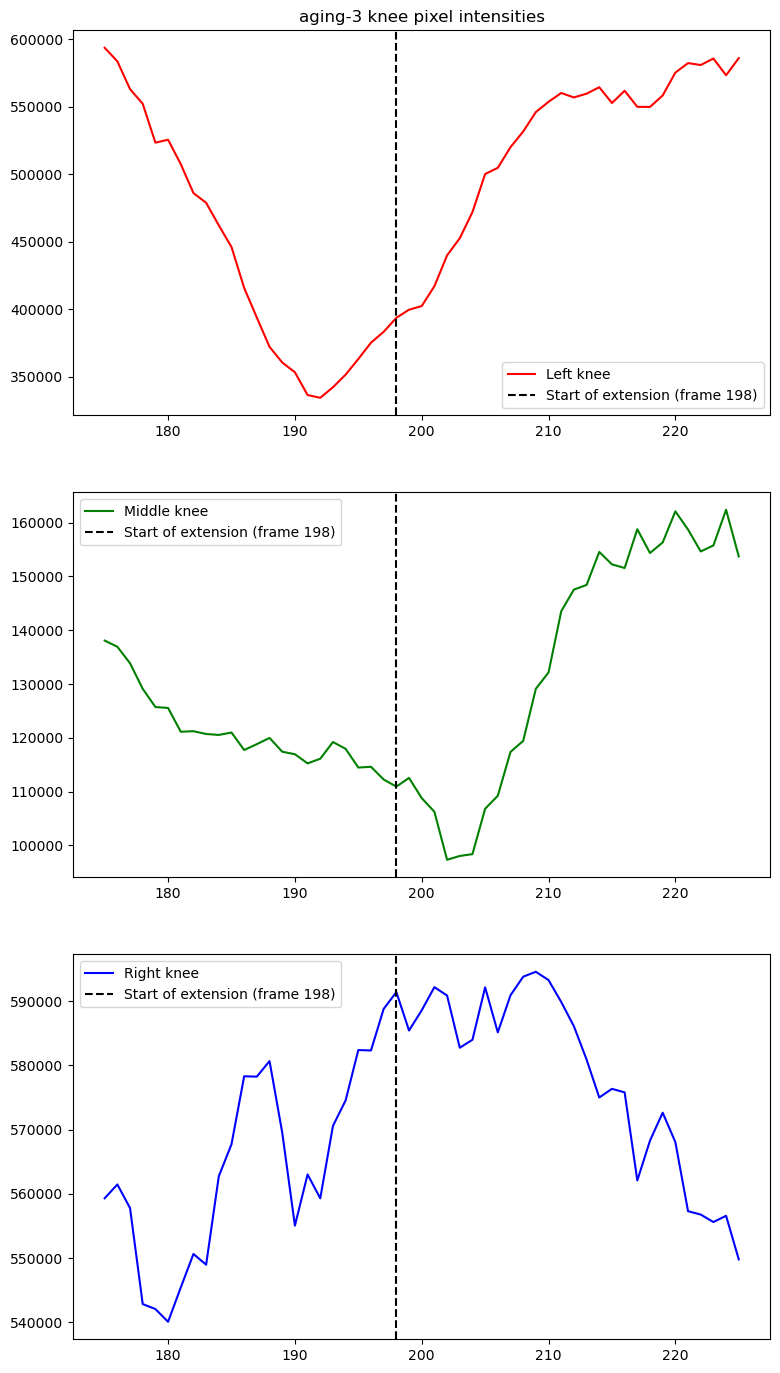

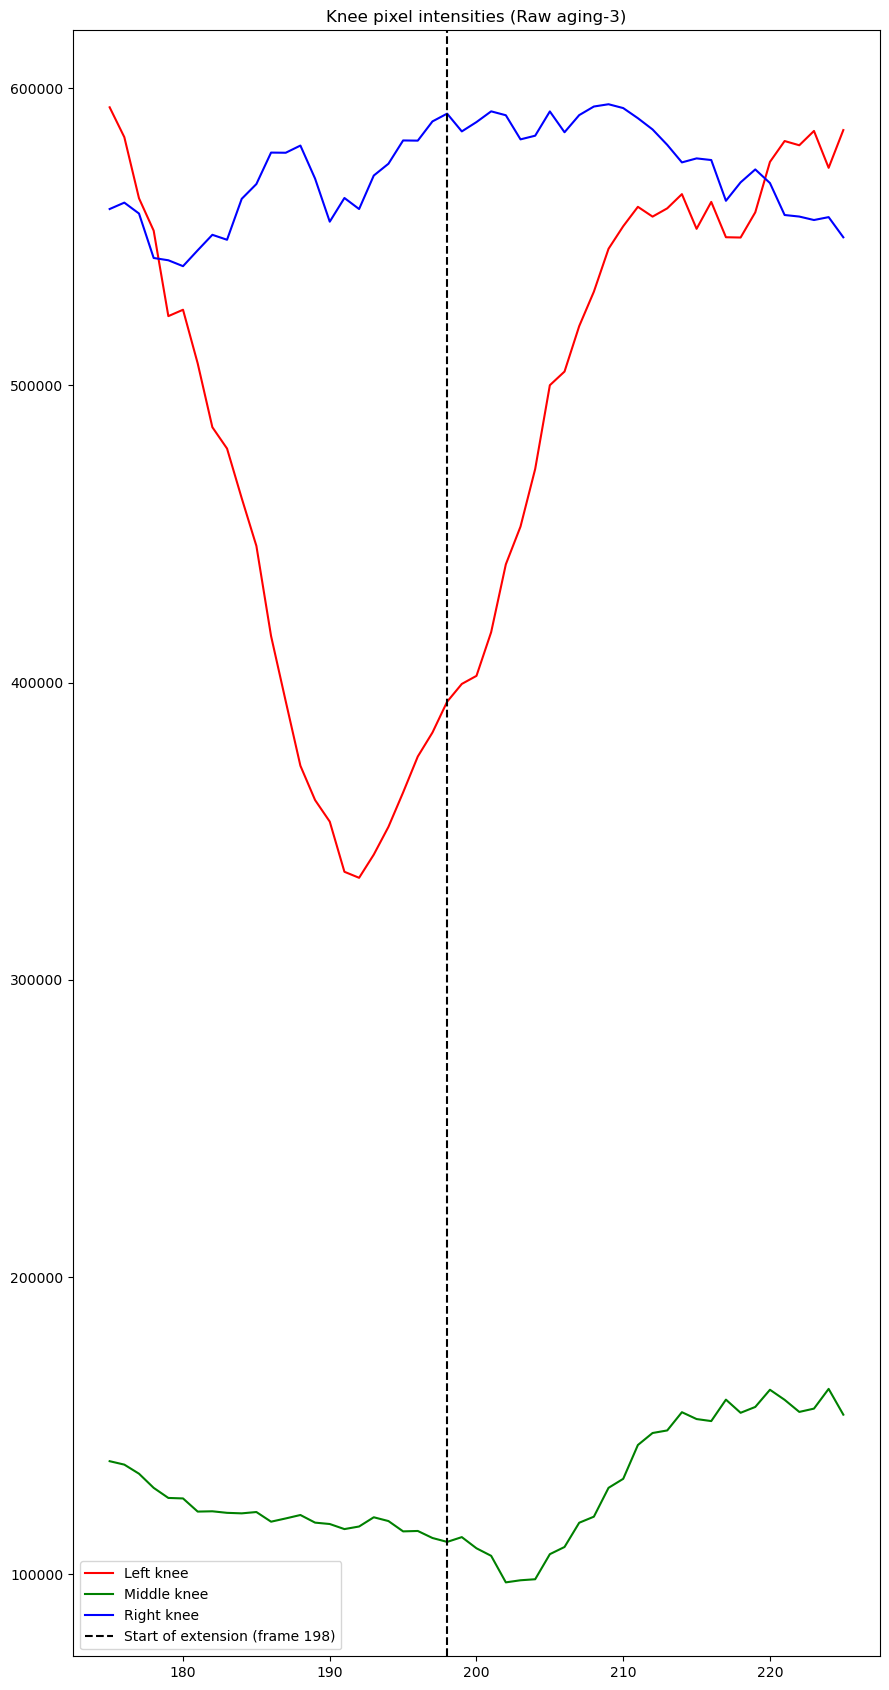

plot_three_intensities() called!
l
m
r


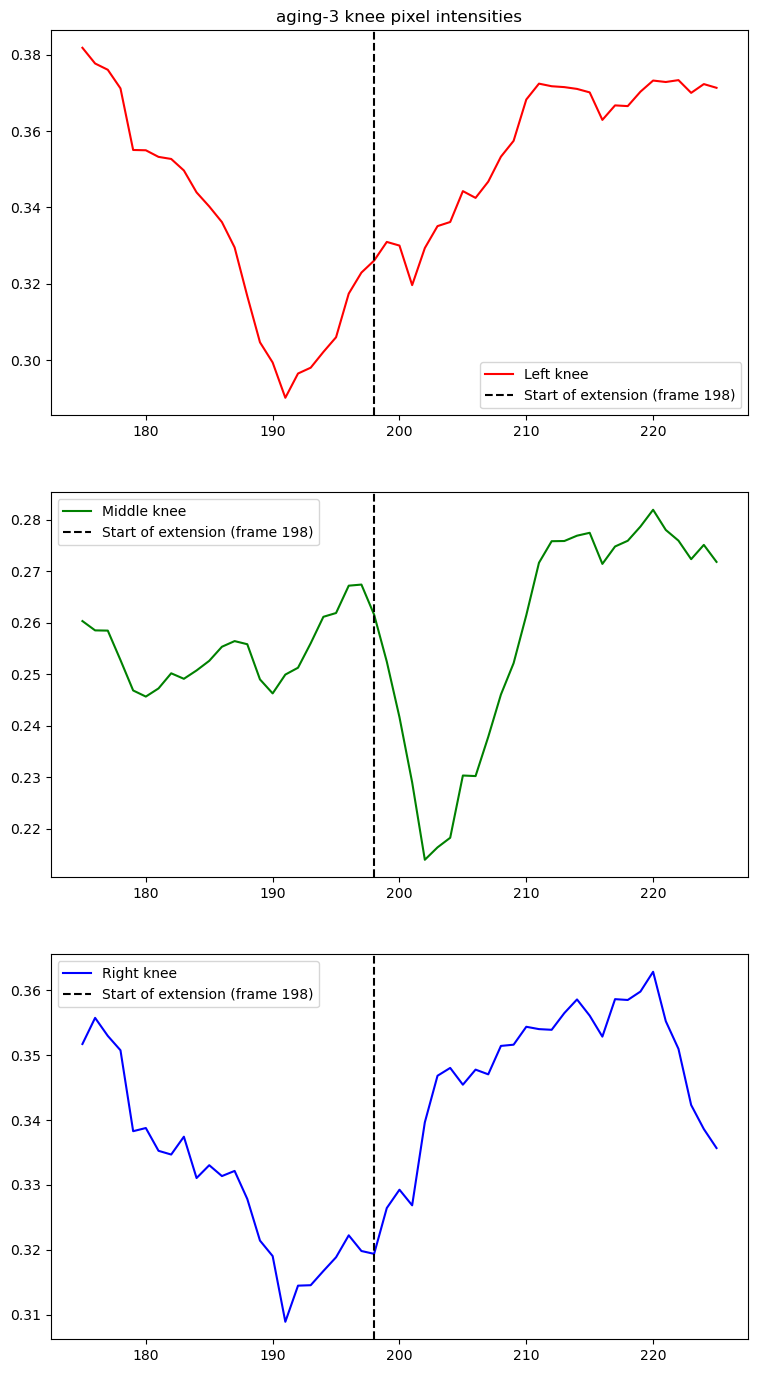

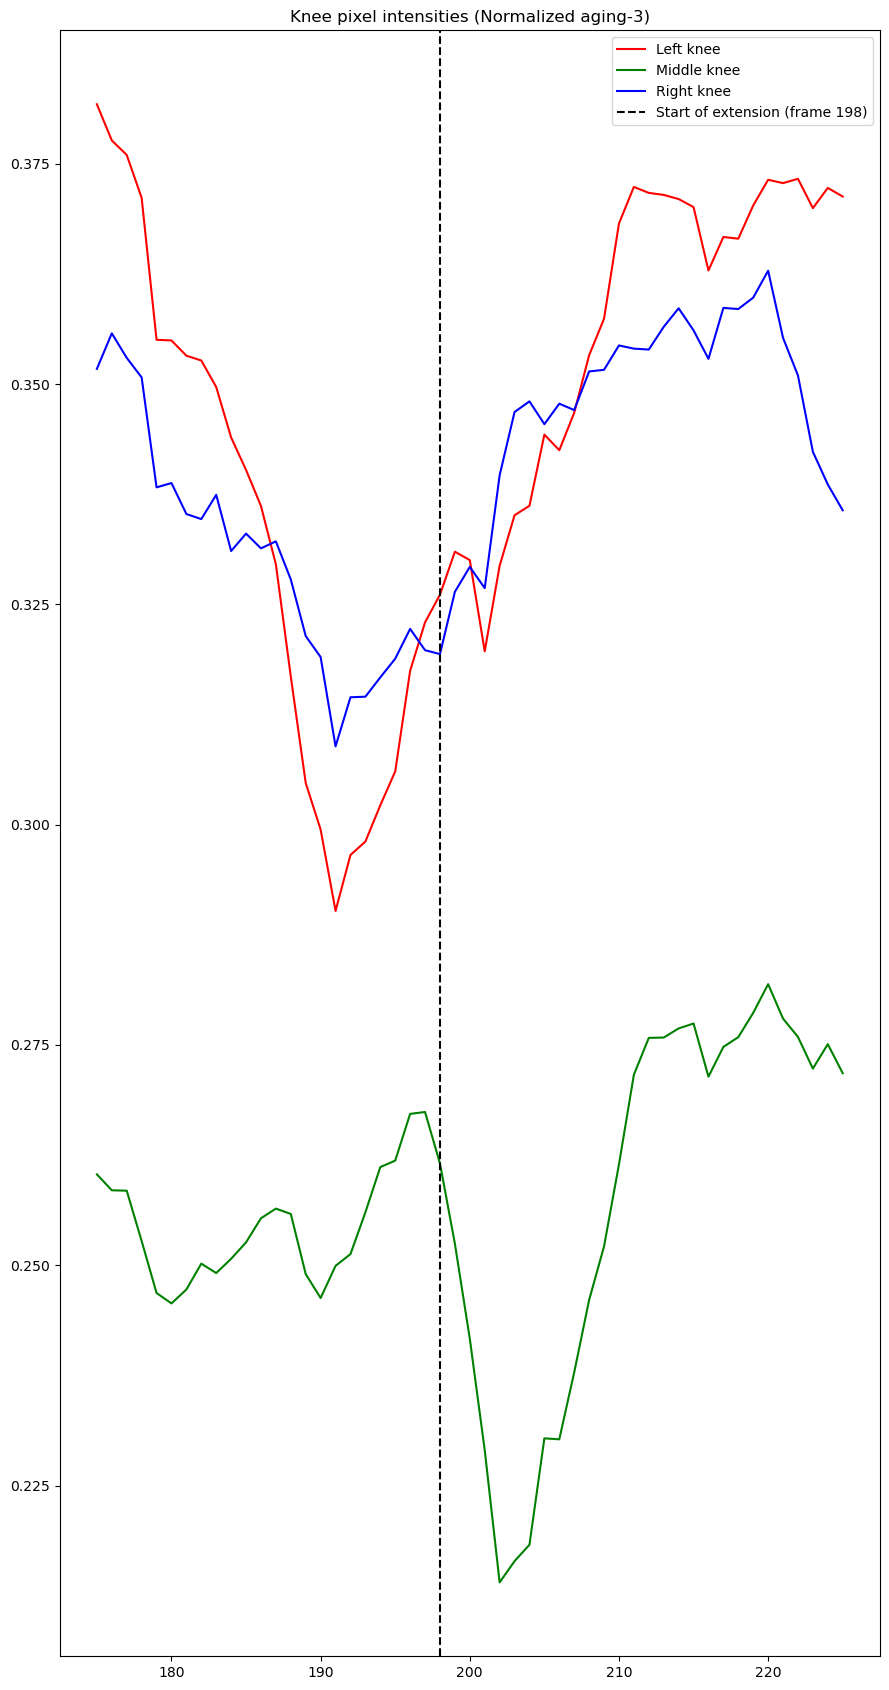

TypeError: analyze_video() got an unexpected keyword argument 'figsize'. Did you mean 'fig_size'?

In [ ]:
if VERBOSE: print("main() called!")

# Load pre-processed video
# video, _ = knee.centre_video(video) 
video = io.load_nparray("../data/processed/aging_knee_processed.npy") # result of above function call
video = video[1:] # Crop out empty first frame
video = np.rot90(video, k=-1, axes=(1,2))
video = utils.crop_video_square(video, int(350*np.sqrt(2))) # wiggle room for black borders

# Slight rotation
angle = -15
video = utils.rotate_video(video, angle)
video = utils.crop_video_square(video, 350) # crop out black borders

# Get adaptive mean mask
mask_src = utils.blur_video(video, (31,31), sigma=0)
# mask_src = utils.log_transform_video(mask_src, 1)
mask = utils.mask_adaptive(mask_src, 71, 10)
# views.show_frames(mask) # Validate mask    

# Get otsu mask
otsu_mask = ks.get_otsu_masks(mask_src)
# otsu_mask = utils.morph_close(otsu_mask, (15,15))
otsu_mask = utils.morph_erode(otsu_mask, (19,19))
# views.show_frames(np.concatenate([mask, otsu_mask], axis=2), "mask vs boundary mask") # Validate 

# Exclude adaptive mean mask outside of otsu mask
intr_mask = rdl.interior_mask(otsu_mask, mask)
intr_mask = utils.morph_close(intr_mask, (11,11))
views.show_frames([mask, intr_mask], "mask vs interior mask") 
# views.draw_mask_boundary(mask_src, intr_mask)

# Estimate the interior boundary
sample_pts = rdl.sample_femur_interior_pts(intr_mask, 128)
views.draw_points(video, sample_pts)

# Estimate the femur tip
tip_bndry = rdl.estimate_femur_tip_boundary(sample_pts, 0.5)
views.draw_points(video, tip_bndry)

tip_bndry = rdl.filter_outlier_points_centroid(tip_bndry, 23)
views.draw_points(video, tip_bndry)

tip_pts = rdl.get_centroid_pts(tip_bndry)
tip_pts = rdl.smooth_points(np.reshape(tip_pts, (-1, 2)), window_size=15)
tip_pts = np.reshape(tip_pts, (-1, 1, 2))
views.draw_points(video, tip_pts)

# Estimate the femur midpoint
midpt_bndry = rdl.estimate_femur_midpoint_boundary(sample_pts, 0, 0.3)
midpt_pts = rdl.get_centroid_pts(midpt_bndry)
midpt_pts = rdl.smooth_points(np.reshape(midpt_pts, (-1, 2)), window_size=15)
midpt_pts = np.reshape(midpt_pts, (-1, 1, 2))
views.draw_points(video, midpt_bndry)
views.draw_points(video, midpt_pts)

# Get radial segmentation
tip_pts = np.reshape(tip_pts, (-1, 2)) # Reshape for interfacing with rdl.get_N_points_on_circle()
tip_pts = [tuple(pts) for pts in tip_pts]
midpt_pts = np.reshape(midpt_pts, (-1, 2))
midpt_pts = [tuple(pts) for pts in midpt_pts]

circle_pts = rdl.get_N_points_on_circle(tip_pts, midpt_pts, N=16, radius_scale=1.5)
views.draw_points(video, circle_pts) # Validate points on circle
radial_regions, radial_masks = get_radial_segments(video, tip_pts, circle_pts, thresh_scale=0.6)

video_demo = views.draw_radial_masks(video, radial_masks, show_video=False) # Validate radial segments
video_demo = views.draw_line(video_demo, tip_pts, midpt_pts, show_video=False)
video_demo = views.draw_radial_slice_numbers(video_demo, circle_pts, show_video=False)
video_demo = views.rescale_video(video_demo, 2, True)

# return

if OUTPUT: io.save_avi("aging_knee_radial_seg_(new_method).avi", video_demo)

"""Reproducing manual segmentation experiment"""

analyze_all_aging_knees(video, radial_masks, radial_regions, show_figs=True, save_figs=False, figsize=(9,17))

analyze_video(video, radial_masks, radial_regions, show_figs=True, save_figs=False, fig_size=None)